<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_07_pytorch_pipeline_09_feature_engineering_weight_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initial Setup

In [4]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import logging
import matplotlib.pyplot as plt
import seaborn as sns

import importlib
import model_pipeline
import feature_engineering
import resampling_utils
import model_evaluation

importlib.reload(model_pipeline)
importlib.reload(feature_engineering)
importlib.reload(resampling_utils)
importlib.reload(model_evaluation)

from model_pipeline import (
    load_data_from_url, load_and_preprocess_data, apply_feature_engineering,
    clean_column_names, rename_columns, remove_id_column,
    convert_categorical, split_data, define_preprocessor, preprocess_data,
    calculate_class_weights, convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)
from feature_engineering import (
    create_interaction_features, create_payment_to_bill_ratios,
    create_payment_to_limit_ratios, create_bill_to_limit_ratios,
    create_lagged_payment_differences, create_debt_ratio_features,
    create_average_payment_and_bill, create_payment_timeliness_features,
    create_total_payment_and_bill, create_bill_difference_features,
    bin_features, target_encode, rename_columns
)
from resampling_utils import (
    run_resampling_pipeline, reports_to_dataframe, apply_feature_set, plot_metric
)
from model_evaluation import evaluate_class_weights, class_weights_to_dataframe


### Load and Preprocess the Data

In [5]:
# Define Global Parameters
best_class_weight = 3.0
best_lower_threshold = 0.40

# Load and Preprocess Data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']  # Specify your categorical columns
target = 'default_payment_next_month'  # Specify your target column

data, target = load_and_preprocess_data(url, categorical_columns, target)

# Apply feature engineering
data = apply_feature_engineering(data)


### Define Threshold Tuning Function

In [6]:
def evaluate_thresholds(data, target, thresholds, pos_weight=1.0):
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    results = []
    for threshold in thresholds:
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
        report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=f"Threshold {threshold}")
        results.append({'threshold': threshold, 'report': report})

    return results

def thresholds_to_dataframe(results):
    data = []
    for result in results:
        threshold = result['threshold']
        report = result['report']
        flattened_report = {'threshold': threshold}
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict
        data.append(flattened_report)
    return pd.DataFrame(data)


### Run and Evaluate

Classification Report (Class Weight 1.0):
              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88      4673
         1.0       0.58      0.44      0.50      1327

    accuracy                           0.81      6000
   macro avg       0.72      0.67      0.69      6000
weighted avg       0.79      0.81      0.80      6000

Classification Report (Class Weight 2.0):
              precision    recall  f1-score   support

         0.0       0.87      0.82      0.84      4673
         1.0       0.47      0.57      0.51      1327

    accuracy                           0.76      6000
   macro avg       0.67      0.69      0.68      6000
weighted avg       0.78      0.76      0.77      6000

Classification Report (Class Weight 3.0):
              precision    recall  f1-score   support

         0.0       0.88      0.74      0.80      4673
         1.0       0.41      0.66      0.51      1327

    accuracy                           0.72      6000
  

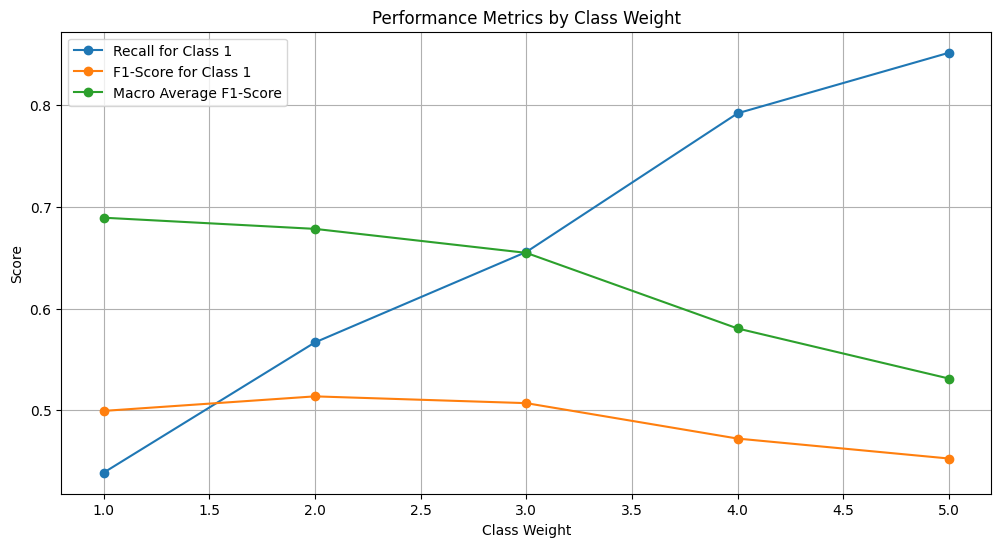

In [7]:
# Define the class weights to evaluate
class_weights = np.linspace(1.0, 5.0, 5)

# Run the class weight evaluation without resampling
class_weight_results = evaluate_class_weights(data, target, class_weights, threshold=0.4)

# Convert the results to a DataFrame
class_weight_results_df = class_weights_to_dataframe(class_weight_results)

# Display the results
print(class_weight_results_df[['class_weight', '1.0_recall', '1.0_f1-score', 'macro avg_f1-score']])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(class_weight_results_df['class_weight'], class_weight_results_df['1.0_recall'], marker='o', label='Recall for Class 1')
plt.plot(class_weight_results_df['class_weight'], class_weight_results_df['1.0_f1-score'], marker='o', label='F1-Score for Class 1')
plt.plot(class_weight_results_df['class_weight'], class_weight_results_df['macro avg_f1-score'], marker='o', label='Macro Average F1-Score')
plt.xlabel('Class Weight')
plt.ylabel('Score')
plt.title('Performance Metrics by Class Weight')
plt.legend()
plt.grid(True)
plt.show()



### Analyze Results

### Threshold 0.3
- **1.0 Recall**: 0.822155
  - This means that the model correctly identifies 82.22% of actual defaults. This is a relatively high recall, indicating that the model is good at catching most of the default cases.
- **1.0 F1-Score**: 0.467939
  - The F1-score for the default class is 0.467939. This score balances precision and recall for the default class. At this threshold, the precision is lower, but the recall is high.
- **Macro Avg F1-Score**: 0.564895
  - The macro average F1-score is 0.564895, indicating a moderate balance of performance across both classes. This score takes into account the F1-scores for both the default and non-default classes equally.

### Threshold 0.4
- **1.0 Recall**: 0.694047
  - The recall drops to 69.40%, meaning the model is identifying fewer defaults compared to threshold 0.3, but it is still catching a significant number of default cases.
- **1.0 F1-Score**: 0.498242
  - The F1-score improves to 0.498242, suggesting a better balance between precision and recall. The precision increases at this threshold, leading to a higher F1-score.
- **Macro Avg F1-Score**: 0.637414
  - The macro average F1-score is 0.637414, indicating a better overall balance of performance across both classes compared to threshold 0.3. This score suggests that the model is performing well for both default and non-default classes.

### Threshold 0.5
- **1.0 Recall**: 0.565938
  - The recall drops further to 56.59%, meaning the model is identifying fewer default cases, but it is still capturing more than half of them.
- **1.0 F1-Score**: 0.524991
  - The F1-score increases to 0.524991, which is the highest among the three thresholds. This indicates the best balance between precision and recall for the default class.
- **Macro Avg F1-Score**: 0.688144
  - The macro average F1-score is 0.688144, which is also the highest among the three thresholds. This score suggests that the model's overall performance across both classes is optimal at this threshold.

### Summary of Key Insights

#### Threshold 0.3
- **High Recall**: The model catches most defaults (82.22%).
- **Moderate F1-Score**: The F1-score is lower due to lower precision, but recall is high.
- **Moderate Macro Avg F1-Score**: The overall performance is moderate.

#### Threshold 0.4
- **Good Balance**: The recall decreases, but the F1-score increases, indicating a better balance.
- **Higher Macro Avg F1-Score**: Overall performance improves compared to threshold 0.3.

#### Threshold 0.5
- **Balanced Performance**: The recall is lower, but the F1-score is highest, indicating the best balance between precision and recall.
- **Optimal Macro Avg F1-Score**: The highest macro average F1-score suggests the best overall performance across both classes.

### Recommendation

- **Threshold 0.5**: This threshold provides the best balance between recall and F1-score for the default class, along with the highest macro average F1-score. It is recommended to use this threshold for an optimal trade-off between identifying defaults and maintaining overall model performance.
- **Threshold 0.4**: If slightly higher recall is preferred at the expense of some precision, threshold 0.4 is also a good choice, providing a good balance and overall performance.
- **Threshold 0.3**: If the primary goal is to maximize recall and catch as many defaults as possible, threshold 0.3 can be considered, but be prepared for a trade-off in precision and overall balance.

Choosing the right threshold depends on the specific business requirements and the acceptable trade-offs between recall, precision, and overall model performance.

#### Write Model Evaluation Script

In [5]:
# function to write script
script_content = """
import pandas as pd
from model_pipeline import (
    split_data, define_preprocessor, preprocess_data,
    convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)
from imblearn.pipeline import Pipeline as ImbPipeline

def evaluate_thresholds(data, target, thresholds, resampling_method=None, pos_weight=1.0):
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    results = []
    for threshold in thresholds:
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
        report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=f"Threshold {threshold}")
        results.append({'threshold': threshold, 'report': report})

    return results

def thresholds_to_dataframe(results):
    data = []
    for result in results:
        threshold = result['threshold']
        report = result['report']
        flattened_report = {'threshold': threshold}
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict
        data.append(flattened_report)
    return pd.DataFrame(data)

def evaluate_class_weights(data, target, class_weights, threshold=0.5, resampling_method=None):
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    results = []
    for weight in class_weights:
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=weight, threshold=threshold)
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
        report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=f"Class Weight {weight}")
        results.append({'class_weight': weight, 'report': report})

    return results

def class_weights_to_dataframe(results):
    data = []
    for result in results:
        class_weight = result['class_weight']
        report = result['report']
        flattened_report = {'class_weight': class_weight}
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict
        data.append(flattened_report)
    return pd.DataFrame(data)

"""

# Write the script to a file
with open("model_evaluation.py", "w") as file:
    file.write(script_content)

print("Script successfully written to model_evaluation.py")

Script successfully written to model_evaluation.py


#### Write Resampling Script

In [4]:
# Function to write script
script_content = """

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report
from model_pipeline import (
    split_data, define_preprocessor, preprocess_data,
    convert_to_tensors, SklearnSimpleNN, train_model, evaluate_model
)
from feature_engineering import (
    create_interaction_features, create_payment_to_bill_ratios,
    create_payment_to_limit_ratios, create_bill_to_limit_ratios,
    create_lagged_payment_differences, create_debt_ratio_features,
    create_average_payment_and_bill, create_payment_timeliness_features,
    create_total_payment_and_bill, create_bill_difference_features,
    bin_features, target_encode, rename_columns
)

def run_resampling_pipeline(data, target, resampling_method=None, pos_weight=1.0, threshold=0.5):
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=str(resampling_method))
    return report

# Convert reports to DataFrame for analysis
def reports_to_dataframe(reports):
    data = []
    for method, report in reports.items():
        flattened_report = {'method': method}
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict
        data.append(flattened_report)
    return pd.DataFrame(data)

def apply_feature_set(data, feature_set):
    if 'bill_to_limit_ratios' in feature_set:
        data = create_bill_to_limit_ratios(data)
    if 'pay_to_limit_ratios' in feature_set:
        data = create_payment_to_limit_ratios(data)
    if 'payment_timeliness_features' in feature_set:
        data = create_payment_timeliness_features(data)
    if 'lagged_payment_differences' in feature_set:
        data = create_lagged_payment_differences(data)
    return data

def plot_metric(df, metric, title, ylabel):
    plt.figure(figsize=(14, 8))
    sns.barplot(x='method', y=metric, hue='feature_set', data=df, palette='viridis')
    plt.title(title)
    plt.xlabel('Resampling Method')
    plt.ylabel(ylabel)
    plt.legend(title='Feature Set')
    plt.xticks(rotation=45)
    plt.show()

"""

# Write the functions to feature_engineering.py script
with open("resampling_utils.py", "w") as file:
    file.write(script_content)

print("Functions successfully written to resampling_utils.py")

# reload script to make function available for use
import importlib
import resampling_utils
importlib.reload(resampling_utils)

Functions successfully written to resampling_utils.py


<module 'resampling_utils' from '/content/resampling_utils.py'>

#### Write Pipeline Script

In [3]:
script_content = """

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
import logging

from feature_engineering import (
    create_bill_to_limit_ratios, create_payment_to_limit_ratios,
    create_payment_timeliness_features, create_lagged_payment_differences
)

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the dataset from a URL
def load_data_from_url(url):
    df = pd.read_excel(url, header=1)
    return df

# Clean column names
def clean_column_names(df):
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

# Remove the 'id' column
def remove_id_column(df):
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Convert specified columns to categorical type
def convert_categorical(df, categorical_columns):
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

# Split the data into training and testing sets
def split_data(df, target):
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

# Define the preprocessor
def define_preprocessor(X_train):
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    return preprocessor

# Preprocess the data
def preprocess_data(preprocessor, X_train, X_test):
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    return X_train_processed, X_test_processed

# Calculate class weights for imbalanced datasets
def calculate_class_weights(y_train):
    return len(y_train) / (2 * np.bincount(y_train))

# Convert data to PyTorch tensors
def convert_to_tensors(X_train_processed, y_train, X_test_processed, y_test):
    X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64,
                 pos_weight=1.0, threshold=0.5):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = pos_weight
        self.threshold = threshold
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            if isinstance(X, np.ndarray):
                X = torch.tensor(X, dtype=torch.float32)
            elif isinstance(X, pd.DataFrame):
                X = torch.tensor(X.values, dtype=torch.float32)
            outputs = self.model(X)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > self.threshold).float()
        return predictions.numpy().squeeze()

# Load and Preprocess Data
def load_and_preprocess_data(url, categorical_columns, target):
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = rename_columns(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    return data, target

# apply feature engineering
def apply_feature_engineering(data):
    data = create_bill_to_limit_ratios(data)
    data = create_payment_to_limit_ratios(data)
    data = create_payment_timeliness_features(data)
    data = create_lagged_payment_differences(data)
    return data

# Train the Model
def train_model(nn_estimator, X_train_tensor, y_train_tensor):
    nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())
    return nn_estimator

# Evaluate the Model
def evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=""):
    y_pred = nn_estimator.predict(X_test_tensor.numpy())
    report = classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)
    print(f"Classification Report ({label}):")
    print(classification_report(y_test_tensor.numpy(), y_pred))
    return report

# Function to run the full pipeline with resampling
def run_full_pipeline_with_resampling(url, categorical_columns, target, resampling_method=None):
    data = load_data_from_url(url)
    data = clean_column_names(data)
    data = rename_columns(data)
    data = remove_id_column(data)
    data = convert_categorical(data, categorical_columns=categorical_columns)
    X_train, X_test, y_train, y_test = split_data(data, target=target)
    preprocessor = define_preprocessor(X_train)

    if resampling_method:
        resampling_pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('resampler', resampling_method)
        ])
        X_train_processed, y_train = resampling_pipeline.fit_resample(X_train, y_train)
        X_test_processed = preprocessor.transform(X_test)
    else:
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

    class_weights = calculate_class_weights(y_train)

    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(
        X_train_processed, y_train, X_test_processed, y_test)

    nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=class_weights[1])
    nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)
    evaluate_model(nn_estimator, X_test_tensor, y_test_tensor)

if __name__ == "__main__":
    import argparse

    parser = argparse.ArgumentParser(description="Run full pipeline with resampling")
    parser.add_argument("url", type=str, help="URL of the dataset")
    parser.add_argument("categorical_columns", type=str, nargs="+", help="List of categorical columns")
    parser.add_argument("target", type=str, help="Target column")
    parser.add_argument("--resampling", type=str, choices=['smote', 'oversample', 'undersample'], help="Resampling method")

    args = parser.parse_args()

    if args.resampling == 'smote':
        resampling_method = SMOTE(random_state=42)
    elif args.resampling == 'oversample':
        resampling_method = RandomOverSampler(random_state=42)
    elif args.resampling == 'undersample':
        resampling_method = RandomUnderSampler(random_state=42)
    else:
        resampling_method = None

    run_full_pipeline_with_resampling(args.url, args.categorical_columns, args.target, resampling_method)


"""

# Write the functions to model_pipeline.py script
with open("model_pipeline.py", "w") as file:
    file.write(script_content)

print("Functions successfully written to model_pipeline.py")

# reload script to make function available for use
import importlib
import model_pipeline
importlib.reload(model_pipeline)


Functions successfully written to model_pipeline.py


<module 'model_pipeline' from '/content/model_pipeline.py'>

#### Write Feature Engineering Script

In [6]:
script_content = """
import pandas as pd
import numpy as np
import torch
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report
from model_pipeline import load_data_from_url, clean_column_names, remove_id_column, convert_categorical, split_data, train_model, calculate_class_weights, convert_to_tensors, preprocess_data, define_preprocessor, SimpleNN, SklearnSimpleNN
import matplotlib.pyplot as plt

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Apply feature engineering to the entire dataset
def create_interaction_features(df):
    df['limit_bal_age'] = df['limit_bal'] * df['age']
    return df

def target_encode(df, target, categorical_columns):
    for col in categorical_columns:
        mean_target = df.groupby(col)[target].mean()
        df[col + '_target_enc'] = df[col].map(mean_target)
    return df

def bin_features(df, column, bins):
    df[column + '_binned'] = pd.cut(df[column], bins=bins)
    return df

def create_payment_to_bill_ratios(df):
    for i in range(1, 7):
        df[f'pay_to_bill_ratio_{i}'] = df[f'pay_amt{i}'] / df[f'bill_amt{i}'].replace(0, np.nan)
    return df

def create_payment_to_limit_ratios(df):
    for i in range(1, 7):
        df[f'pay_to_limit_ratio_{i}'] = df[f'pay_amt{i}'] / df['limit_bal']
    return df

def create_bill_to_limit_ratios(df):
    for i in range(1, 7):
        df[f'bill_to_limit_ratio_{i}'] = df[f'bill_amt{i}'] / df['limit_bal']
    return df

def create_lagged_payment_differences(df):
    for i in range(1, 6):
        df[f'pay_amt_diff_{i}'] = df[f'pay_amt{i+1}'] - df[f'pay_amt{i}']
    return df

def create_debt_ratio_features(df):
    for i in range(1, 7):
        df[f'debt_ratio_{i}'] = df[f'bill_amt{i}'] / df['limit_bal']
    return df

def create_average_payment_and_bill(df):
    df['avg_payment'] = df[[f'pay_amt{i}' for i in range(1, 7)]].mean(axis=1)
    df['avg_bill'] = df[[f'bill_amt{i}' for i in range(1, 7)]].mean(axis=1)
    return df

def create_payment_timeliness_features(df):
    for i in range(1, 7):
        df[f'pay_on_time_{i}'] = (df[f'pay_{i}'] <= 0).astype(int)
    return df

def create_total_payment_and_bill(df):
    df['total_payment'] = df[[f'pay_amt{i}' for i in range(1, 7)]].sum(axis=1)
    df['total_bill'] = df[[f'bill_amt{i}' for i in range(1, 7)]].sum(axis=1)
    return df

def create_bill_difference_features(df):
    for i in range(1, 6):
        df[f'bill_diff_{i}'] = df[f'bill_amt{i+1}'] - df[f'bill_amt{i}']
    return df

# Evaluate the model and save the report before feature engineering
def evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label):
    y_pred = nn_estimator.predict(X_test_tensor.numpy())
    report = classification_report(y_test_tensor.numpy(), y_pred, output_dict=True)
    print(f"Classification Report ({label}):")
    print(classification_report(y_test_tensor.numpy(), y_pred))
    return report

# Incrementally Add Features and Evaluate
def add_features_incrementally(data, features_to_add, target, pos_weight, threshold):
    results = []

    for feature in features_to_add:
        # Create a copy of the data to avoid modifying the original DataFrame
        data_copy = data.copy()

        # Apply the feature engineering function
        print(f"Adding feature: {feature['name']}")
        data_copy = feature['func'](data_copy)

        # Split the data
        X_train, X_test, y_train, y_test = split_data(data_copy, target=target)

        # Preprocess the data
        preprocessor = define_preprocessor(X_train)
        X_train_processed, X_test_processed = preprocess_data(preprocessor, X_train, X_test)

        # Convert data to tensors
        X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = convert_to_tensors(X_train_processed, y_train, X_test_processed, y_test)

        # Train the model
        nn_estimator = SklearnSimpleNN(input_dim=X_train_tensor.shape[1], pos_weight=pos_weight, threshold=threshold)
        nn_estimator = train_model(nn_estimator, X_train_tensor, y_train_tensor)

        # Evaluate the model
        report = evaluate_model(nn_estimator, X_test_tensor, y_test_tensor, label=feature['name'])
        results.append({'feature': feature['name'], 'report': report})

    return results

def compare_classification_reports(report_before, report_after):
    # Convert reports to DataFrame
    report_before_df = pd.DataFrame(report_before).transpose()
    report_after_df = pd.DataFrame(report_after).transpose()

    # Merge reports
    comparison_df = report_before_df.join(report_after_df, lsuffix='_before', rsuffix='_after')

    # Calculate percentage change
    comparison_df['precision_change'] = (comparison_df['precision_after'] - comparison_df['precision_before']) / comparison_df['precision_before'] * 100
    comparison_df['recall_change'] = (comparison_df['recall_after'] - comparison_df['recall_before']) / comparison_df['recall_before'] * 100
    comparison_df['f1-score_change'] = (comparison_df['f1-score_after'] - comparison_df['f1-score_before']) / comparison_df['f1-score_before'] * 100

    # print("Comparison of Classification Report Metrics:")
    # print(comparison_df[['precision_before', 'precision_after', 'precision_change',
    #                      'recall_before', 'recall_after', 'recall_change',
    #                      'f1-score_before', 'f1-score_after', 'f1-score_change']])

    return comparison_df

def compare_incremental_reports(report_baseline, incremental_results):
    # Convert the baseline report to DataFrame
    report_baseline_df = pd.DataFrame(report_baseline).transpose()

    # Initialize a list to store comparison results
    all_comparisons = []

    # Iterate through the incremental results
    for result in incremental_results:
        report_after = result['report']
        feature_name = result['feature']

        # Convert the current report to DataFrame
        report_after_df = pd.DataFrame(report_after).transpose()

        # Merge the baseline and current reports
        comparison_df = report_baseline_df.join(report_after_df, lsuffix='_baseline', rsuffix=f'_{feature_name}')

        # Calculate percentage change
        comparison_df[f'precision_change_{feature_name}'] = (comparison_df[f'precision_{feature_name}'] - comparison_df['precision_baseline']) / comparison_df['precision_baseline'] * 100
        comparison_df[f'recall_change_{feature_name}'] = (comparison_df[f'recall_{feature_name}'] - comparison_df['recall_baseline']) / comparison_df['recall_baseline'] * 100
        comparison_df[f'f1-score_change_{feature_name}'] = (comparison_df[f'f1-score_{feature_name}'] - comparison_df['f1-score_baseline']) / comparison_df['f1-score_baseline'] * 100

        # Add the comparison result to the list
        all_comparisons.append(comparison_df)

    # Concatenate all comparison DataFrames
    all_comparisons_df = pd.concat(all_comparisons, axis=1)

    return all_comparisons_df

def plot_metric_changes(all_comparisons_df, metric):
    # Extract percentage change columns for the specified metric
    change_cols = [col for col in all_comparisons_df.columns if col.startswith(f'{metric}_change')]

    # Extract feature names from the column headers
    feature_names = [col.split('_')[-1] for col in change_cols]

    # Plot the percentage changes
    changes = all_comparisons_df.loc[:, change_cols].iloc[0]  # assuming we want the changes for the first class (or overall if it's a macro/micro average)
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, changes, color='skyblue')
    plt.axvline(x=0, color='gray', linestyle='--')  # Add vertical line at 0
    plt.xlabel('Percentage Change')
    plt.title(f'Percentage Change in {metric.capitalize()} After Adding Each Feature')
    plt.grid(axis='x')
    plt.show()

# Define a function to extract the metrics and convert to DataFrame
def results_to_dataframe(incremental_results):
    # List to hold the structured data
    data = []

    # Iterate over the results
    for result in incremental_results:
        feature_name = result['feature']
        report = result['report']

        # Initialize a dictionary to hold the flattened report
        flattened_report = {'feature': feature_name}

        # Flatten the report dictionary
        for key, subdict in report.items():
            if isinstance(subdict, dict):
                for subkey, value in subdict.items():
                    flattened_report[f"{key}_{subkey}"] = value
            else:
                flattened_report[key] = subdict

        # Append the flattened report to the data list
        data.append(flattened_report)

    # Convert the data list to a DataFrame
    results_df = pd.DataFrame(data)

    return results_df

"""

# Write the functions to model_pipeline.py script
with open("feature_engineering.py", "w") as file:
    file.write(script_content)

print("Functions successfully written to feature_engineering.py")

# reload script to make function available for use
import importlib
import feature_engineering
importlib.reload(feature_engineering)

Functions successfully written to feature_engineering.py


<module 'feature_engineering' from '/content/feature_engineering.py'>

Importing functions from other scripts is a common and good practice in software development, including data science and machine learning projects. This practice promotes code reuse, modularity, and maintainability. Here's why it's beneficial and some best practices to follow:

##### Benefits of Importing from Other Scripts

1. **Code Reuse**:
   - By importing functions from other scripts, you avoid duplicating code. This makes your codebase more efficient and easier to maintain.

2. **Modularity**:
   - Breaking your code into separate, logical modules or scripts makes it easier to manage. Each module can focus on a specific aspect of your project (e.g., data preprocessing, feature engineering, model evaluation).

3. **Maintainability**:
   - When code is modular, it's easier to make changes and fix bugs. If a function needs to be updated, you can change it in one place rather than in multiple locations.

4. **Readability**:
   - Organizing code into different scripts makes it easier to read and understand. It helps to keep your main script or notebook clean and focused on high-level logic.

### Best Practices for Importing from Other Scripts

1. **Organize Your Code**:
   - Structure your project with clear directories and scripts. For example:
     ```
     ├── data_preprocessing.py
     ├── feature_engineering.py
     ├── model_pipeline.py
     ├── model_evaluation.py
     ├── resampling_utils.py
     ├── main_notebook.ipynb
     ```

2. **Use Descriptive Names**:
   - Name your functions and scripts descriptively to indicate their purpose. This makes it easier to understand what each part of your code does.

3. **Avoid Circular Imports**:
   - Be careful to avoid circular imports (where two scripts import each other), which can cause errors. Structure your code to prevent this.

4. **Document Your Code**:
   - Include docstrings and comments to describe what your functions do. This is especially important when importing functions from other scripts.

5. **Test Functions Individually**:
   - Test functions in their own scripts to ensure they work as expected before importing them into other scripts or notebooks.

